In [ ]:
# Name: Changjun Zai
# ID: 1127473900
# Email: czai@usc.edu
# Date: April 14, 2022

In [ ]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(1-train_losses, color='blue', label='Training accuracy') 
    ax.plot(1-valid_losses, color='red', label='Test accuracy')
    ax.set(title="accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)

        
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [ ]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Test loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Test accuracy: {0.5+100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

# RANDOM_SEED = 42
# LEARNING_RATE = 0.005
# BATCH_SIZE = 32
# N_EPOCHS = 15

# IMG_SIZE = 32
# N_CLASSES = 10

# RANDOM_SEED = 42
# LEARNING_RATE = 0.001
# BATCH_SIZE = 8
# N_EPOCHS = 10

# IMG_SIZE = 32
# N_CLASSES = 10


In [ ]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

07:53:35 --- Epoch: 0	Train loss: 0.1842	Test loss: 0.0851	Train accuracy: 97.56	Test accuracy: 97.74
07:54:37 --- Epoch: 1	Train loss: 0.0777	Test loss: 0.0650	Train accuracy: 98.29	Test accuracy: 98.51
07:55:40 --- Epoch: 2	Train loss: 0.0593	Test loss: 0.0559	Train accuracy: 98.82	Test accuracy: 98.80
07:56:43 --- Epoch: 3	Train loss: 0.0512	Test loss: 0.0535	Train accuracy: 98.92	Test accuracy: 98.85
07:57:46 --- Epoch: 4	Train loss: 0.0434	Test loss: 0.0541	Train accuracy: 98.88	Test accuracy: 98.86
07:58:50 --- Epoch: 5	Train loss: 0.0401	Test loss: 0.0467	Train accuracy: 99.14	Test accuracy: 99.03
07:59:53 --- Epoch: 6	Train loss: 0.0361	Test loss: 0.0551	Train accuracy: 99.06	Test accuracy: 98.84
08:00:56 --- Epoch: 7	Train loss: 0.0330	Test loss: 0.0525	Train accuracy: 99.25	Test accuracy: 98.92
08:01:59 --- Epoch: 8	Train loss: 0.0300	Test loss: 0.0513	Train accuracy: 99.31	Test accuracy: 99.07
08:03:02 --- Epoch: 9	Train loss: 0.0278	Test loss: 0.0492	Train accuracy: 99.21	T

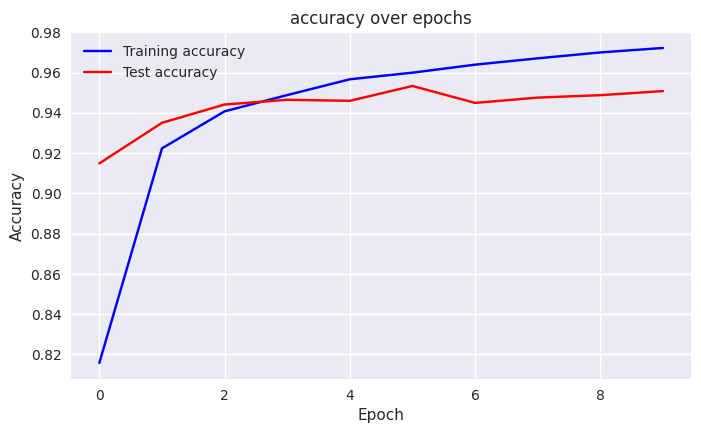

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

In [ ]:
# Drawing confusion matrix
def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

conf_matrix = torch.zeros(10, 10)

for data, target in valid_loader:
  data = data.to(DEVICE)
  output = model(data)
  conf_matrix = confusion_matrix(output[1], target, conf_matrix)

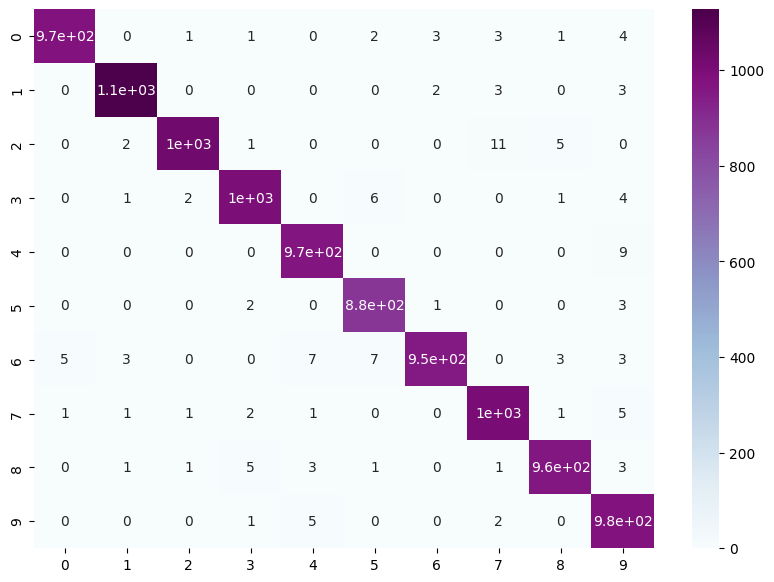

In [ ]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(conf_matrix.numpy())
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="BuPu")

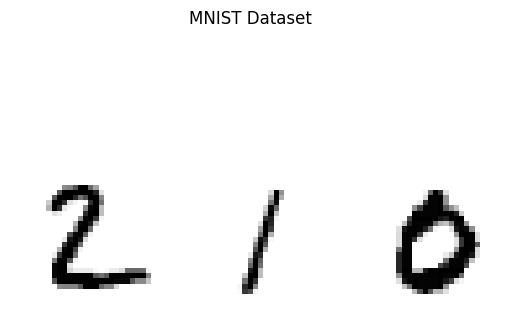

In [ ]:
ROW_IMG = 3
N_ROWS = 1
fig = plt.figure()

data_index=[1,2,3] #The largest of the confusion matrix

for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[data_index[index-1]], cmap='gray_r')
fig.suptitle('MNIST Dataset');